# Results Summary

Importing libraries:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Defining constants:

In [2]:
MODELS = ['deepCNN', 'CNN', 'transformer', 'LSTM', 'shapelet+XGB', 'stats+XGB', 'SN', 'DATW', 'DTW']
RESULTS_DIR = './results/'

Displaying aggregated classification scores:

In [3]:
results_df = pd.DataFrame()
for model_name in MODELS:
    if model_name == 'DATW':
        file = os.path.join(RESULTS_DIR, model_name, 'DATW_closed_set', f'{model_name}_clf_scores.csv')
    elif model_name == 'SN':
        file = os.path.join(RESULTS_DIR, model_name, 'SN_closed_set', f'{model_name}_clf_scores.csv')
    else:
        file = os.path.join(RESULTS_DIR, model_name, f'{model_name}_clf_scores.csv')
    per_class_errors_df = pd.read_csv(file)
    per_class_errors_df.index = [model_name]
    results_df = pd.concat([results_df, per_class_errors_df])
results_df = results_df.sort_values(by='f1-score macro avg', ascending=False)
results_df['rank'] = np.arange(1, len(results_df) + 1)
results_df.to_csv(os.path.join(RESULTS_DIR, 'closed_set_setting_overall_results.csv'))
results_df[['accuracy', 'f1-score macro avg', 'f1-score weighted avg']].style.background_gradient(cmap='Blues').to_latex(
    os.path.join(RESULTS_DIR, 'closed_set_setting_overall_results.tex'), convert_css=True, hrules=True)
results_df.style.background_gradient(cmap='Blues')

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg,rank
DATW,0.814815,0.813844,0.816143,0.838235,0.843621,0.817647,0.814815,1
DTW,0.802469,0.801356,0.797943,0.827451,0.824809,0.806863,0.802469,2
stats+XGB,0.790123,0.793791,0.790809,0.811905,0.817842,0.800980,0.790123,3
deepCNN,0.753086,0.749097,0.742187,0.772269,0.767196,0.762745,0.753086,4
SN,0.753086,0.748969,0.746741,0.788235,0.795679,0.766667,0.753086,5
LSTM,0.753086,0.746446,0.748488,0.785294,0.787757,0.750000,0.753086,6
CNN,0.679012,0.680768,0.673759,0.711555,0.707128,0.688235,0.679012,7
shapelet+XGB,0.679012,0.669873,0.671839,0.701261,0.704027,0.677451,0.679012,8
transformer,0.641975,0.611932,0.616041,0.659150,0.668024,0.642157,0.641975,9


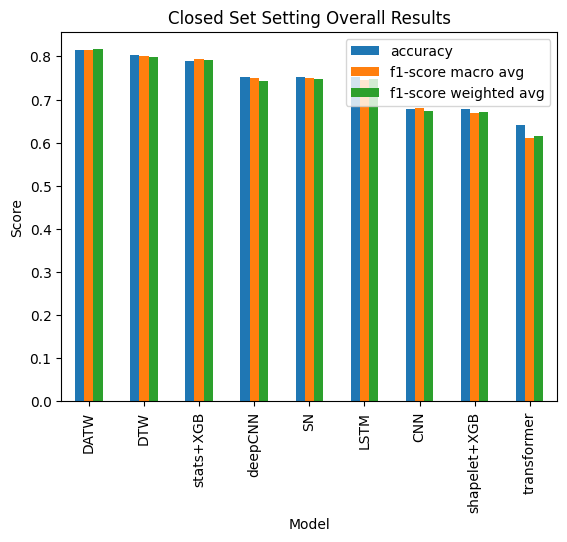

In [4]:
results_df[['accuracy', 'f1-score macro avg', 'f1-score weighted avg']].plot.bar(
    title='Closed Set Setting Overall Results',
    xlabel='Model',
    ylabel='Score'
);

- DATW performs best across all metrics.
- DTW is close, suggesting that attention mechanisms in DATW add a measurable (but modest) boost over standard DTW.
- stats+XGB shows that handcrafted features still perform well, beating more complex models like CNNs and transformers.
- deepCNN / SN / LSTM all have moderate accuracy and F1 scores.
- CNN / shapelet+XGB / transformer models show lower performance. CNN and especially the Transformer model likely need more data.
- The small gap between macro and weighted F1 indicates that class performance is fairly balanced, showing minimal bias toward more frequent classes despite mild imbalance.

**Confusion matrices**

<img src="./results/DATW/DATW_closed_set/DATW_confusion_matrix.png" style="width:33%;"/><img src="./results/DTW/DTW_confusion_matrix.png" style="width:33%;"/><img src="./results/SN/SN_closed_set/SN_confusion_matrix.png" style="width:33%;"/>

<img src="./results/LSTM/LSTM_confusion_matrix.png" style="width:33%;"/><img src="./results/CNN/CNN_confusion_matrix.png" style="width:33%;"/><img src="./results/deepCNN/deepCNN_confusion_matrix.png" style="width:33%;"/>

<img src="./results/shapelet+XGB/shapelet+XGB_confusion_matrix.png" style="width:33%;"/><img src="./results/stats+XGB/stats+XGB_confusion_matrix.png" style="width:33%;"/><img src="./results/transformer/transformer_confusion_matrix.png" style="width:33%;"/>

Loading data and model predictions to compute additional metrics:

In [5]:
data = np.load('./dataset/dataset.npz')
X_test = data['X_test']
y_test = data['y_test']
ids_test = data['ids_test']
y_mapping = data['y_mapping']
y_test_str= [y_mapping[label] for label in y_test]

cm = np.zeros((len(y_mapping), len(y_mapping)), dtype=int)
errors = np.zeros(y_test.shape[0])

for model_name in MODELS:
    if model_name == 'DATW':
        file = os.path.join(RESULTS_DIR, model_name, 'DATW_closed_set', f'{model_name}_predictions.npy')
    elif model_name == 'SN':
        file = os.path.join(RESULTS_DIR, model_name, 'SN_closed_set', f'{model_name}_predictions.npy')
    else:
        file = os.path.join(RESULTS_DIR, model_name, f'{model_name}_predictions.npy')
    y_model = np.load(file)
    y_model_str = [y_mapping[label] for label in y_model]
    model_cm = confusion_matrix(y_test_str, y_model_str)
    cm += model_cm
    errors += (y_model != y_test).astype(int)

errors /= len(MODELS)
errors = errors * 100

Displaying per class missclassification rates across models:

In [6]:
per_class_errors_df = pd.DataFrame({
    'misclassified': cm.sum(axis=1) - np.diag(cm),
    'total': cm.sum(axis=1),
    'missclassification %': 100 * (cm.sum(axis=1) - np.diag(cm)) / cm.sum(axis=1)
})
per_class_errors_df.index = [y_mapping[i] for i in range(len(y_mapping))]
per_class_errors_df = per_class_errors_df.sort_values(by='missclassification %', ascending=False)
per_class_errors_df.style.background_gradient(cmap='Blues', subset=['total', 'missclassification %'])

,misclassified,total,missclassification %
ball,18,36,50.000000
cylinder,20,45,44.444444
lemon,20,45,44.444444
labello,18,45,40.000000
smallbutton,21,54,38.888889
smallcube,15,45,33.333333
cube,12,36,33.333333
button,17,54,31.481481
jenga,11,36,30.555556
bigball,13,45,28.888889


- The classes `empty`, `metalbrick`, and `box` were perfectly classified by all models.
- The classes `ball`, `cylinder`, `lemon`, and `labello` exhibit the highest misclassification rates.
- These patterns indicate that some object classes are inherently more challenging to distinguish based on tactile and proprioceptive signals, while others are consistently easy to recognize.
- Again, missclassification rate is not correlated with class frequency, indicating that the models are not biased towards more frequent classes.

Visualizing aggregated confusion matrix:

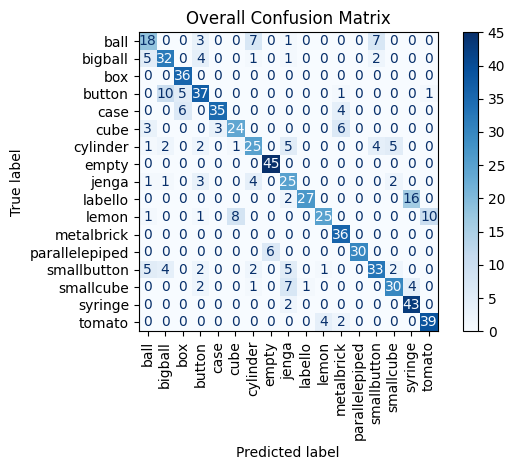

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_str))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title('Overall Confusion Matrix')
plt.tight_layout()

Regarding the most misclassified classes, the confusion matrix shows that:
- `ball` is often confused with `cylinder` and `smallbutton`.
- `cylinder` is frequently misclassified with multiple classes.
- `lemon` is commonly confused with `cube` and `tomato`.
- `labello` is often misclassified with `syringe`.
- Misclassifications are not always reciprocal.

Displaying object ids sorted by missclassification rate:

In [ ]:
errors_df = pd.DataFrame(errors, columns=['missclassification %'], index=ids_test)
errors_df.sort_values(by='missclassification %', ascending=False, inplace=True)
errors_df[errors_df['missclassification %']>0].style.background_gradient(cmap='Blues')

,missclassification %
cube_30,100.000000
smallbutton_27,100.000000
cylinder_24,100.000000
ball_18,100.000000
bigball_15,88.888889
smallcube_41,88.888889
case_43,88.888889
lemon_31,77.777778
cylinder_43,77.777778
lemon_03,77.777778


In [9]:
print("Percentage of samples with no missclassification: {:.2f}%".format(len(errors_df[errors_df['missclassification %']==0]) / len(errors_df) * 100))
print("Percentage of samples with missclassification: {:.2f}%".format(len(errors_df[errors_df['missclassification %']>0]) / len(errors_df) * 100))

Percentage of samples with no missclassification: 41.98%
Percentage of samples with missclassification: 58.02%


Displaying time series of objects misclassified by all models:

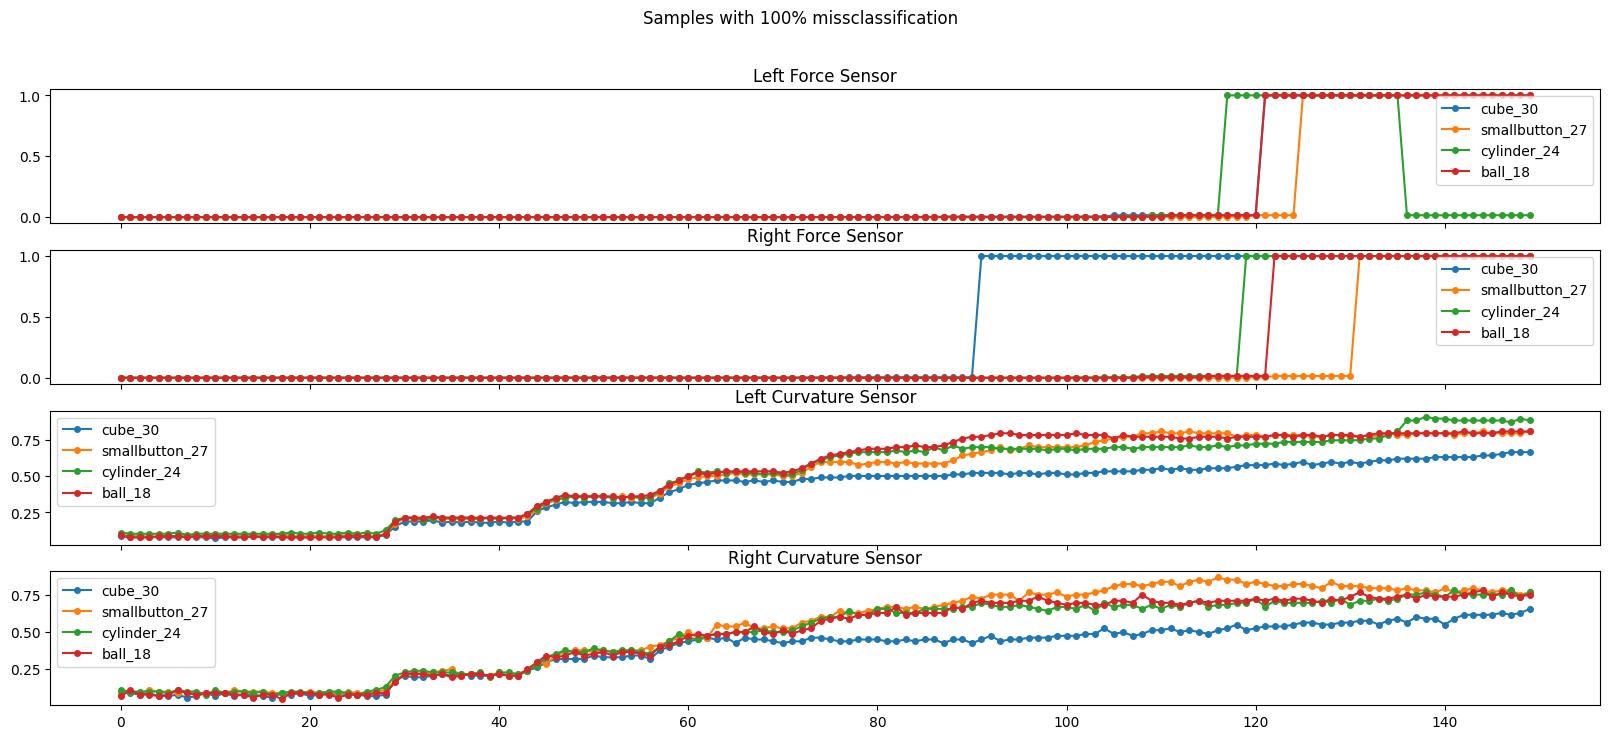

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(20, 8), sharex=True)
for wrong_id in errors_df[errors_df['missclassification %']==100].index.to_list():
    wrong_index = np.where(ids_test == wrong_id)[0][0]
    wrong_data = X_test[wrong_index]
    axs[0].plot(wrong_data[:, 0], '-o', label=wrong_id, markersize=4)
    axs[1].plot(wrong_data[:, 1], '-o', label=wrong_id, markersize=4)
    axs[2].plot(wrong_data[:, 2], '-o', label=wrong_id, markersize=4)
    axs[3].plot(wrong_data[:, 3], '-o', label=wrong_id, markersize=4)
axs[0].legend()
axs[0].set_title(f'Left Force Sensor')
axs[1].legend()
axs[1].set_title(f'Right Force Sensor')
axs[2].legend()
axs[2].set_title(f'Left Curvature Sensor')
axs[3].legend()
axs[3].set_title(f'Right Curvature Sensor');
fig.suptitle('Samples with 100% missclassification');

- A subset of instances, such as cube_30, smallbutton_27, cylinder_24, and ball_18, are misclassified 100% of the time, indicating that these specific examples may possess ambiguous or non-representative features that confuse all classifiers. Though such ambiguity is not immediately evident from their time series plots.
- Many other instances exhibit low or even zero misclassification, demonstrating that the dataset is not entirely noisy or inconsistent.

**XGB feature importance**

<img src="./results/stats+XGB/stats+XGB_feature_importances.png" style="width:50%;"/>

The feature importance analysis using XGBoost reveals that the left force sensor contributes the most to the model's decisions, with 7 of the top 17 features (those having a feature importance value higher than 0.02) derived from it.

Regarding the types of statistical features, there is no single dominant statistic. The most frequently occurring ones are skewness and 90th percentile, each appearing 3 times among the top 17 features.

## Few-shot learning

In [11]:
datw_10s_df = pd.read_csv('./results/DATW/DATW_10shot/DATW_clf_scores.csv', index_col=0)
datw_10s_df.index = [f'DATW 10-shot {idx}' for idx in datw_10s_df.index]
datw_5s_df = pd.read_csv('./results/DATW/DATW_5shot/DATW_clf_scores.csv', index_col=0)
datw_5s_df.index = [f'DATW 5-shot {idx}' for idx in datw_5s_df.index]
sn_10s_df = pd.read_csv('./results/SN/SN_10shot/SN_clf_scores.csv', index_col=0)
sn_10s_df.index = [f'SN 10-shot {idx}' for idx in sn_10s_df.index]
sn_5s_df = pd.read_csv('./results/SN/SN_5shot/SN_clf_scores.csv', index_col=0)
sn_5s_df.index = [f'SN 5-shot {idx}' for idx in sn_5s_df.index]
few_shot_df = pd.concat([datw_10s_df, datw_5s_df, sn_10s_df, sn_5s_df])
few_shot_df = few_shot_df.sort_values(by='f1-score macro avg', ascending=False)
few_shot_df['rank'] = np.arange(1, len(few_shot_df) + 1)
few_shot_df.to_csv(os.path.join(RESULTS_DIR, 'few-shot_setting_overall_results.csv'))
few_shot_df.style.background_gradient(cmap='Blues')

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg,rank
DATW 10-shot New Ref,0.881081,0.884006,0.880193,0.886104,0.886736,0.888947,0.881081,1
DATW 5-shot New Ref,0.861905,0.863981,0.863310,0.869240,0.871661,0.865531,0.861905,2
SN 10-shot New Ref,0.837838,0.836266,0.830519,0.840945,0.841129,0.849009,0.837838,3
SN 5-shot New Ref,0.790476,0.791284,0.786153,0.796458,0.795877,0.800155,0.790476,4
DATW 10-shot Sub Ref,0.664865,0.299011,0.765835,0.361445,0.939097,0.262507,0.664865,5
DATW 5-shot Sub Ref,0.552381,0.221240,0.670770,0.303783,0.914065,0.181341,0.552381,6
SN 10-shot Sub Ref,0.481081,0.207921,0.609293,0.297154,0.884410,0.165181,0.481081,7
SN 10-shot Full Ref,0.427027,0.190487,0.557227,0.306569,0.917325,0.147199,0.427027,8
DATW 10-shot Full Ref,0.464865,0.189817,0.586929,0.299038,0.957131,0.153196,0.464865,9
SN 5-shot Sub Ref,0.366667,0.155858,0.501406,0.286839,0.913621,0.113555,0.366667,10


- Both models have successfully learned a discriminative metric, as they are able to correctly classify objects from novel classes. However, they tend to confuse novel classes with previously seen classes, suggesting that their learned representations are not fully disentangled across class boundaries. E.g., `parallelepiped` is often misclassified as `labello`, `smallbutton` as `ball`, `smallcube` as `jenga`, `syringe` as `jenga` and `tomato` as `lemon`.
- DATW consistently outperforms Siamese Networks in few-shot learning across all settings.
- For both models, using a subset of the training set for computing distances to the query set leads to notable performance improvements over using all training data, likely because the metric space is less dominated by previously seen classes. Further gains might be achieved by weighting neighbors based on distance, rather than using uniform voting.
- 10-shot learning achieves better performance than 5-shot learning.
- Notably, DATW incurs significantly higher computational cost compared to Siamese Networks, which may limit its suitability for real-time applications. This is because DATW must perform a forward pass through the entire reference set for each query, whereas Siamese Networks only require a single forward pass through the query, leveraging precomputed embeddings of the reference set.

**DATW, 5-shot**

<img src="./results/DATW/DATW_5shot/DATW_confusion_matrix_full_ref.png" style="width:33%;"/><img src="./results/DATW/DATW_5shot/DATW_confusion_matrix_sub_ref.png" style="width:33%;"/><img src="./results/DATW/DATW_5shot/DATW_confusion_matrix_new_ref.png" style="width:33%;"/>

**SN, 5-shot**

<img src="./results/SN/SN_5shot/SN_confusion_matrix_full_ref.png" style="width:33%;"/><img src="./results/SN/SN_5shot/SN_confusion_matrix_sub_ref.png" style="width:33%;"/><img src="./results/SN/SN_5shot/SN_confusion_matrix_new_ref.png" style="width:33%;"/>


**DATW, 10-shot**

<img src="./results/DATW/DATW_10shot/DATW_confusion_matrix_full_ref.png" style="width:33%;"/><img src="./results/DATW/DATW_10shot/DATW_confusion_matrix_sub_ref.png" style="width:33%;"/><img src="./results/DATW/DATW_10shot/DATW_confusion_matrix_new_ref.png" style="width:33%;"/>

**SN, 10-shot**

<img src="./results/SN/SN_10shot/SN_confusion_matrix_full_ref.png" style="width:33%;"/><img src="./results/SN/SN_10shot/SN_confusion_matrix_sub_ref.png" style="width:33%;"/><img src="./results/SN/SN_10shot/SN_confusion_matrix_new_ref.png" style="width:33%;"/>

## SN embeddings

### Closed set

<img src="./results/SN/SN_closed_set/embeddings_plot.png" style="width:100%;"/>

In the t-SNE projection of the embedding space, embeddings of the training data form distinct and well-separated clusters, suggesting that the Siamese network has learned a meaningful representation of the classes. Embeddings of validation and testing data remain fairly well clustered, though some instances are mapped into regions associated with different classes. This could indicate that these particular samples are inherently ambiguous or difficult to distinguish, or potentially reflect some degree of overfitting—though no clear signs of overfitting were observed in the training and validation curves.

### Few-shot setting

<img src="./results/SN/SN_5shot/embeddings_plot.png" style="width:50%;"/>

In the t-SNE projection of the embedding space, embeddings of the unseen classes generally form coherent clusters. However, these clusters are often elongated and partially intrude into regions occupied by previously seen classes. The most prominent overlap occurs between the ‘tomato’ and ‘lemon’ classes, which are mapped to closely neighboring regions.